# Stock Price Forecasting using LSTM

This notebook implements a deep learning–based time series forecasting model to predict stock prices and quantify uncertainty using confidence intervals.

Model Type: LSTM  
Forecast Horizon: 7 Days  
Dataset: Yahoo Finance (OHLCV)


In [2]:
!pip install pandas_datareader

In [3]:
!pip install yfinance

In [4]:
#Importing Dataset from Yahoo
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
df = yf.download('GE',start = '2021-01-01',end = '2026-01-01')


[*********************100%***********************]  1 of 1 completed


In [5]:
#Printing Dataset
#We dont need to reset index, as date is automatically set as index here with datatype of datetime64[ns]
df.head()
df['Close_original'] = df['Close']

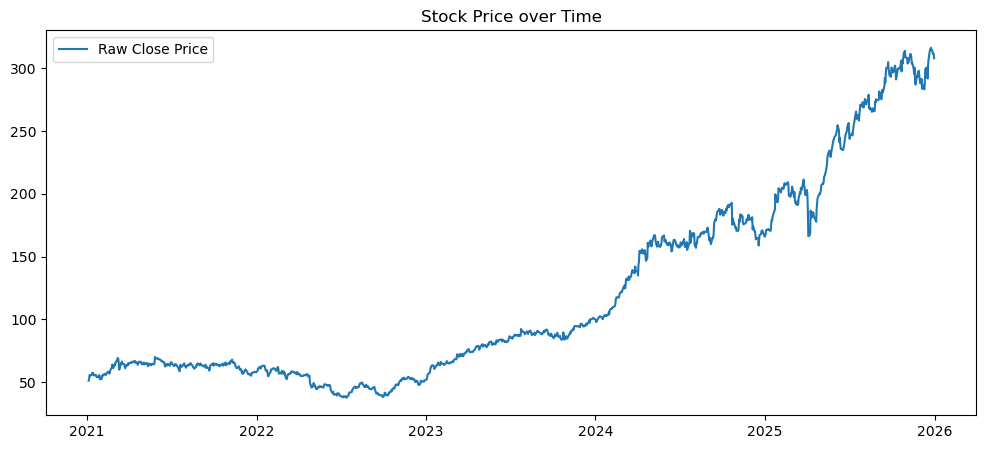

In [6]:
#Importing matplotlib library for plots
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.plot(df.Close, label = "Raw Close Price")
plt.title("Stock Price over Time")
plt.legend()
plt.show()

##  Feature Engineering

To capture market momentum and risk, the following features are engineered:
- Daily Returns
- Rolling Volatility (20-day)
- Trading Volume

These features help the model learn both price movement and uncertainty.


In [7]:
# Simple Returns
df['returns'] = df['Close'].pct_change()


In [8]:
#Finding rolling mean of last 20 days
df['rolling_mean'] = df['returns'].rolling(window = 20).mean()
#Volatility = Standard deviation over last 20 days
df['Volatility'] = df['returns'].rolling(window=20).std()


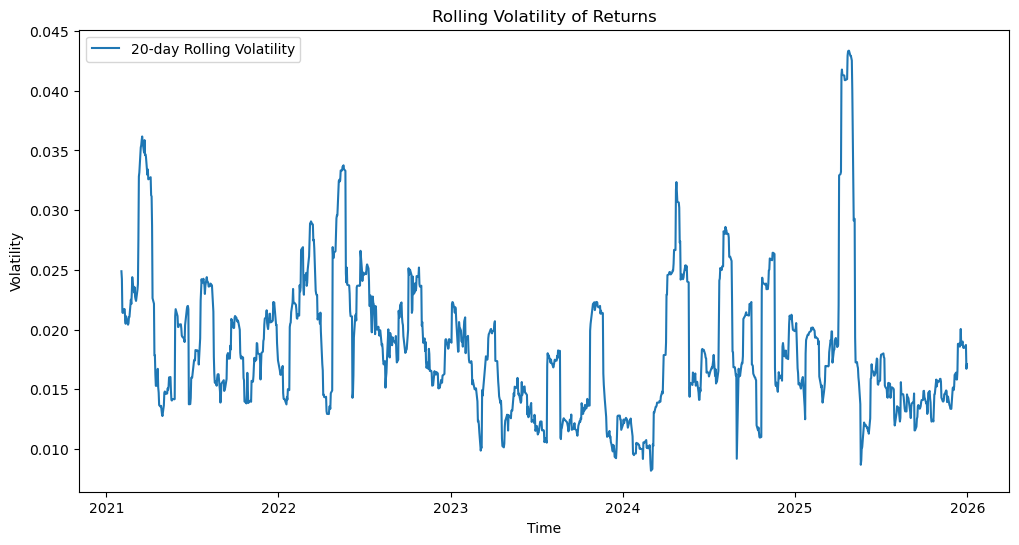

In [9]:
#Plotting these data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volatility'], label='20-day Rolling Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title('Rolling Volatility of Returns')
plt.legend()
plt.show()


In [10]:
#Dropping any of the NaN values from the dataframe and making its copy.
df = df.dropna().copy()

In [11]:
#Features selection for the model
features = ['Close','returns','Volatility','Volume']
df['Close_original'] = df['Close']

##  Train-Test Split

The dataset is split chronologically:
- 80% Training data
- 20% Testing data

This preserves the time-series nature of the data and avoids leakage.


In [12]:
# Splitting the data into Train and Test datas
train_size = int(len(df)*0.8)      # 80% of the data of the dataframe is udes for training the model.
df_train = df.iloc[:train_size]    # Training data till train_size.
df_test = df.iloc[train_size:]     # Testing data from train_size to ennd of df.

SCALING THE DATA

In [13]:
# Scaling the training data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train[features])
test_scaled = scaler.transform(df_test[features])

In [14]:
# Now we got the fetures for testing and training , now converting them back to the dataframes..
# These scaled dataframes will be working as input for the model.
df_train_scaled = pd.DataFrame(train_scaled, columns=features, index=df_train.index)
df_test_scaled = pd.DataFrame(test_scaled, columns=features, index=df_test.index)

##  Time Series Windowing

A sliding window of **30 days** is used.
Each input sample contains price and momentum information from the previous 30 days to predict the next day.


In [15]:
window_size = 30
x, y = [], []

train_array = df_train_scaled[features].values

In [16]:
import numpy as np

# Windowing the data will help in prediction of next day data with the help of data of last 30 days.
for i in range(window_size, len(train_array)):
    # Fix: Use i-window_size:i to get a consistent window size
    x.append(train_array[i-window_size:i])   # creates a 3D array having (samples, timestamps, features)
    y.append(train_array[i, 0])              # creates a 1D array

# Move these outside the loop to convert to numpy arrays only once after all data is collected
x = np.array(x)
y = np.array(y)

In [17]:
split = int(0.8 * len(x))
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]

In [18]:
# x_train array will have "i no. of samples" , "window_size no. of timestamps" , "features no. of features"

##  LSTM Model Architecture

An LSTM network is used to capture temporal dependencies in stock price movements.
Dropout is applied to reduce overfitting.


In [19]:
!pip install tensorflow

In [20]:
# Using Tensorflow - A deep learning engine
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# Layer by layer stacking , like a container, creating a pipeline in which one layer's output is another's input.
model = Sequential([
    LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])         # Keeps a single output


C:\anacond\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compliling the model
model.compile(
    optimizer = 'adam',          
    # Optimizers used to minimize the loss.
    # Used adam optimizer as it adjusts learning rate itself.
    loss = 'mse',
    # Loss function for measurement of error and mistakes.
    # We used mse as it is better for time series and stock analysis.
    metrics = ['mae']
    # Metrics are used to show performances.
)

In [26]:

#Early stopping - Stopping the model early to avoid overfitting.
early_stop = EarlyStopping(
    monitor = 'val_loss',     # It sees the validation loss.
    patience = 5,            # If no improvement till 5 epochs -> stop.
    restore_best_weights = True    
    # Restores the best model.
)

MODEL TRAINING AND FITTING

In [27]:
history = model.fit(
    x_train,       # input features
    y_train,       # target features
    # xtrain and ytrain are what the model is learning.
    validation_data = (x_val , y_val),
    # this data is for testing the model.
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop],
    verbose = 1                # 1 Output => progress bar + loss
    )

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0446 - mae: 0.1644 - val_loss: 0.3330 - val_mae: 0.5732
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0085 - mae: 0.0693 - val_loss: 0.0473 - val_mae: 0.2062
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - mae: 0.0511 - val_loss: 0.0297 - val_mae: 0.1621
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - mae: 0.0426 - val_loss: 0.0088 - val_mae: 0.0794
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - mae: 0.0397 - val_loss: 0.0034 - val_mae: 0.0508
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - mae: 0.0368 - val_loss: 0.0031 - val_mae: 0.0475
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - mae: 0.0336 - val_loss: 0.0029 - val_mae: 0.0464
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - mae: 0.0338 - val_loss: 0.0033 - val_mae: 0.0462
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.001

##  Multi-step Forecasting (7 Days)

The trained model is used to recursively predict stock prices for the next 7 business days using a rolling window approach.


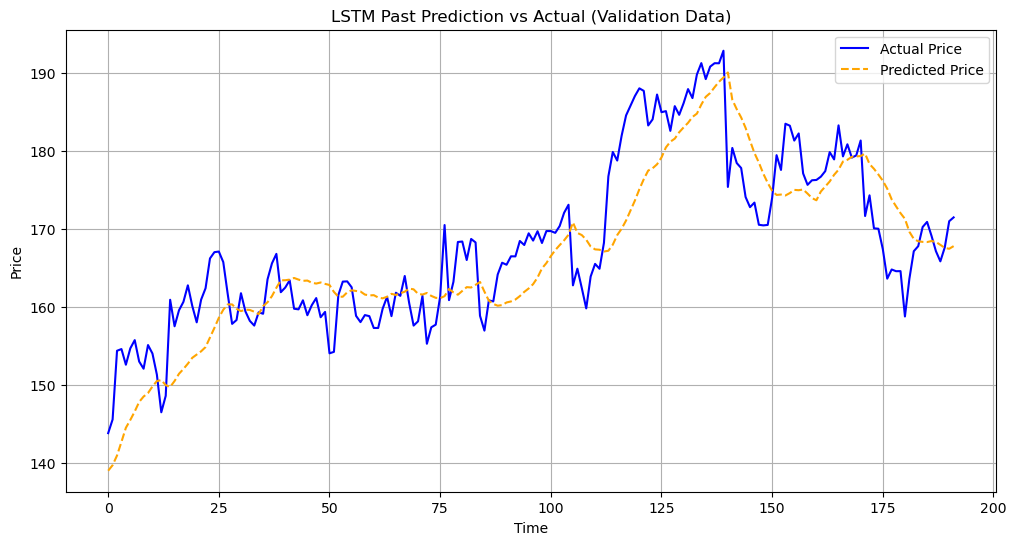

In [31]:
plt.figure(figsize=(12,6))

plt.plot(
    y_val_true_inv,
    label="Actual Price",
    color="blue"
)

plt.plot(
    y_val_pred_inv,
    label="Predicted Price",
    color="orange",
    linestyle="--"
)

plt.title("LSTM Past Prediction vs Actual (Validation Data)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


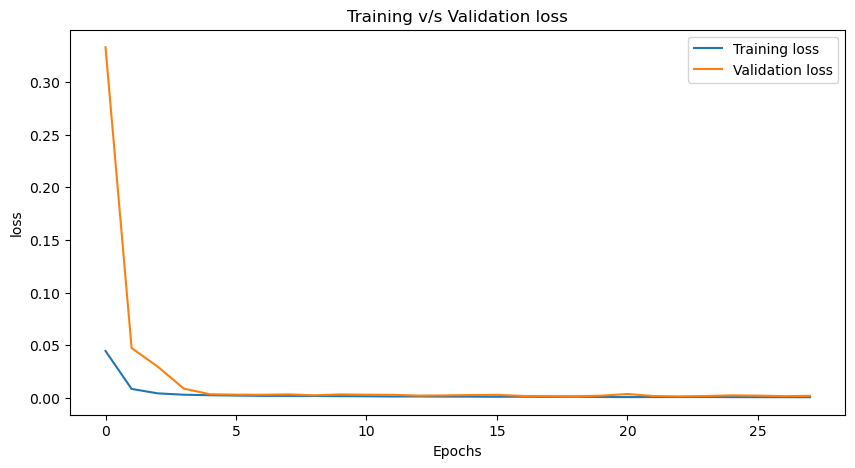

In [32]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"] , label = "Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title("Training v/s Validation loss")
plt.legend()
plt.show()

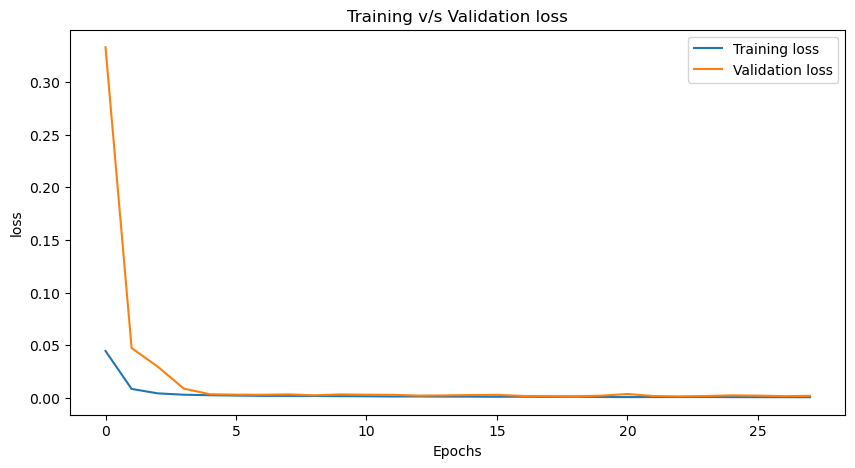

In [33]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"], label = "Training loss")
plt.plot(history.history["val_loss"] , label = "Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title("Training v/s Validation loss")
plt.legend()
plt.show()

NOW 7 DAYS FORECASTING

In [34]:
close_col = features.index('Close')

last_window = df_test_scaled[features].iloc[-window_size:].values
current_window = last_window.reshape(1, window_size, len(features))

In [40]:
future_close_scaled = []

for _ in range(7):
    pred = model.predict(current_window, verbose=0)
    next_close = pred[0, 0]
    future_close_scaled.append(next_close)

    next_row = current_window[:, -1, :].copy()
    next_row[0, close_col] = next_close
    next_row = current_window[:, -1, :].copy()
    next_row[0, close_col] = next_close

    current_window = np.concatenate(
        [current_window[:, 1:, :], next_row.reshape(1,1,-1)],
        axis=1
    )

In [42]:
future_close_scaled = []

for _ in range(7):
    pred = model.predict(current_window, verbose=0)
    next_close = pred[0, 0]
    future_close_scaled.append(next_close)

    next_row = current_window[:, -1, :].copy()
    next_row[0, close_col] = next_close

    current_window = np.concatenate(
        [current_window[:, 1:, :], next_row.reshape(1,1,-1)],
        axis=1
    )


In [43]:
dummy = np.zeros((7, len(features)))
dummy[:, close_col] = future_close_scaled
future_prices = scaler.inverse_transform(dummy)[:, close_col]


In [44]:
future_dates = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=7,
    freq='B'
)

PLOT OF THE PREDICTION :

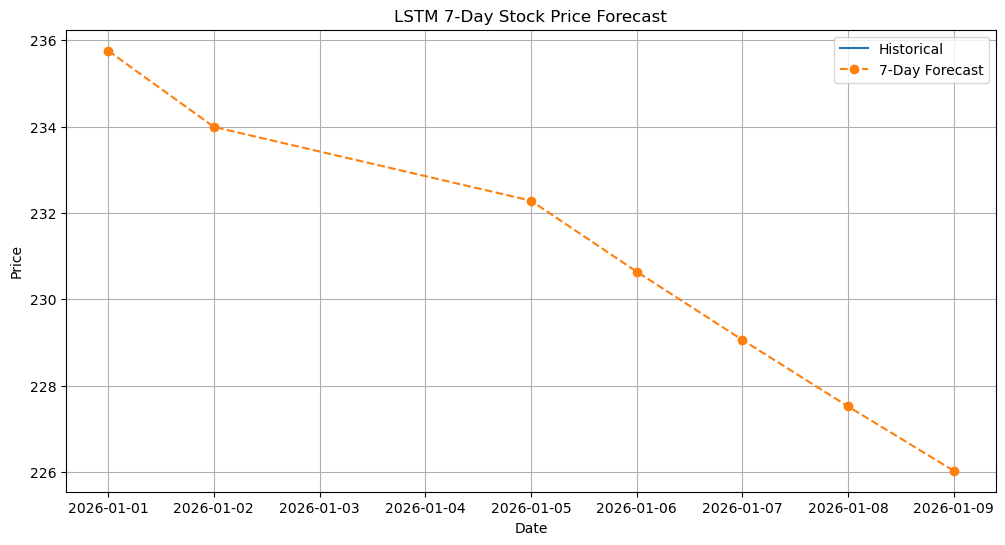

In [45]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-50:], df['Close_original'].iloc[-50:], label='Historical')
plt.plot(future_dates, future_prices, marker='o', linestyle='--', label='7-Day Forecast')
plt.title("LSTM 7-Day Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

##  Confidence Interval Estimation

Since financial markets are uncertain, confidence intervals are calculated using recent volatility.
This provides an estimated range of possible future prices.


In [49]:
recent_vol = df['returns'].iloc[-30:].std()
print("Recent Volatility:", recent_vol)


Recent Volatility: 0.017897824815876703


In [50]:
k = 2  # 95% confidence

upper_bound = future_prices * (1 + k * recent_vol)
lower_bound = future_prices * (1 - k * recent_vol)
